In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [98]:
rootDir = os.getcwd()
trainDir = os.path.join(rootDir, 'antrenare')
templatesDir = os.path.join(rootDir, 'imagini_auxiliare/templates/')
trainImages = os.listdir(trainDir)
trainImages = sorted([image for image in trainImages if '.jpg' in image])
trainImagesCopy = trainImages.copy()

In [89]:
def showImage(title, image, grayscale=True):
    colorMap = None
    if grayscale == True:
        colorMap = 'gray'
    image=cv.resize(image,(0,0),fx=0.3,fy=0.3)
    plt.imshow(image, cmap=colorMap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [90]:
nGames = 4

nCells = 14
board = np.full((nCells, nCells), -1)
multiplier = np.ones((nCells, nCells))
rows = [i for i in range(14)]
cols = [chr(ord('A') + i) for i in range(14)]

for i in range(5):
    multiplier[i][i] = 2
    multiplier[i + 9][i + 9] = 2
    multiplier[nCells - i - 1][i] = 2
    multiplier[i][nCells - i - 1] = 2

multiplier[0][0] = 3
multiplier[0][6] = 3
multiplier[0][7] = 3
multiplier[0][13] = 3
multiplier[6][0] = 3
multiplier[6][13] = 3
multiplier[7][0] = 3
multiplier[7][13] = 3
multiplier[13][0] = 3
multiplier[13][6] = 3
multiplier[13][7] = 3
multiplier[13][13] = 3

constraints = {
    (2, 5): "/",
    (2, 10): "/",
    (3, 6): "-",
    (3, 9): "-",
    (5, 2): "/",
    (5, 7): "+",
    (5, 8): "*",
    (5, 13): "/",
    (6, 3): "-",
    (6, 12): "-",
    (7, 4): "*",
    (7, 5): "+",
    (7, 10): "*",
    (7, 11): "+",
    (8, 4): "+",
    (8, 5): "*",
    (8, 10): "+",
    (8, 11): "*",
    (9, 3): "-",
    (9, 12): "-",
    (10, 2): "/",
    (10, 7): "+",
    (10, 8): "*",
    (10, 13): "/",
    (11, 7): "*",
    (11, 8): "+",
    (12, 6): "-",
    (12, 9): "-",
    (13, 5): "/",
    (13, 10): "/"    
}

pieces = {
    0: 1, 
    
    1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 
    
    11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1,
    
    20: 1, 21: 1, 24: 1, 25: 1, 27: 1, 28: 1,
    
    30: 1, 32: 1, 35: 1, 36: 1,
    
    40: 1, 42: 1, 45: 1, 48: 1, 49: 1,
    
    50: 1, 54: 1, 56: 1,
    
    60: 1, 63: 1, 64: 1,
    
    70: 1, 72: 1,
    
    80: 1, 81: 1,
    
    90: 1
}

In [91]:
# Iterez prin jocuri - i
# pentru fiecare joc, citesc i_turns.txt
# iterez prin miscarile jucatorului
# la fiecare miscare, gasesc tabla
#                       gasesc noua piesa (diferenta de la tabla anterioara la cea actuala)
#                       identific piesa
#                       verific ecuatiile pe care le indeplineste
#                       aplic constrangeri si bonusuri
# 
# Game -> Turn -> round

In [ ]:
def getBoard(img):
    boardMaskLow = (100, 50, 50)
    boardMaskHigh = (140, 255, 255)

    hsvImage = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    boardMask = cv.inRange(hsvImage, boardMaskLow, boardMaskHigh)

    contours, _ = cv.findContours(boardMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largestContour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(largestContour)

    cutoutBoard = img[y : y + h, x : x + w]

    return cutoutBoard


In [93]:
def resizeBoard(board, width, height):
    board = cv.resize(board, (width, height), interpolation=cv.INTER_LINEAR)
    return board

In [94]:
def matchPiece(piece):
    correlations = []
    for i in pieces.keys():
        templateImagePath = os.path.join(templatesDir, f'{i}.jpg')
        templateImage = cv.imread(templateImagePath)

        corr = cv.matchTemplate(piece, templateImage,  cv.TM_CCOEFF_NORMED)
        corr=np.max(corr)
        correlations.append(corr)

    return list(pieces.keys())[np.argmax(correlations)]

In [95]:
boardTemplatePath = os.path.join(templatesDir, '01.jpg')
boardTemplate = cv.imread(boardTemplatePath)
boardTemplate = getBoard(boardTemplate)
boardTemplate = resizeBoard(boardTemplate, 1980, 1980)

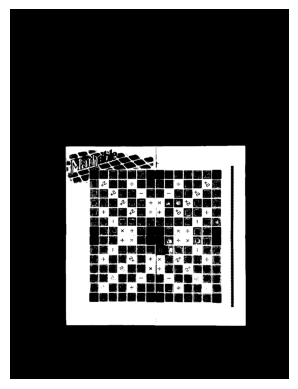

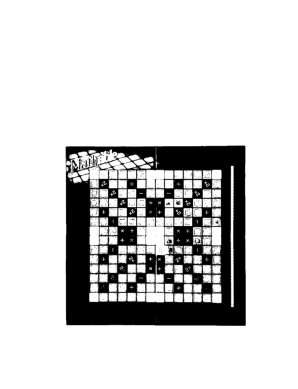

(1975, 1976, 3)


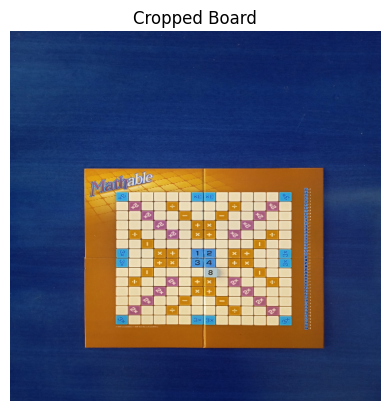

Identified piece as 63


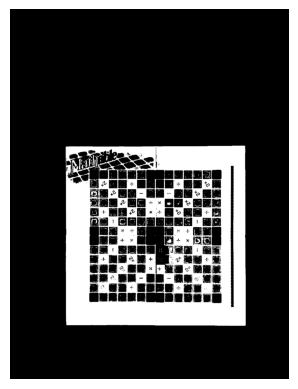

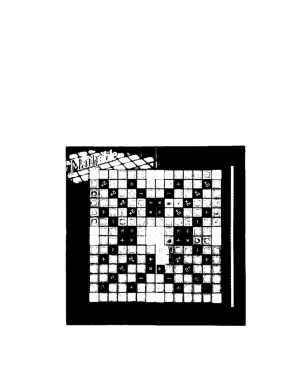

(57, 89, 3)


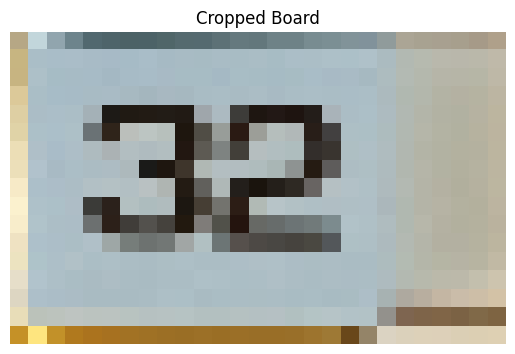

Identified piece as 5


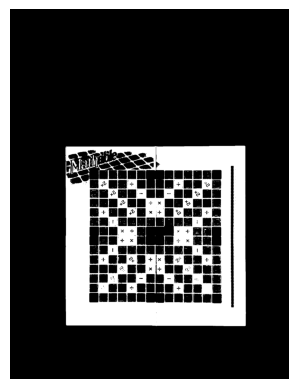

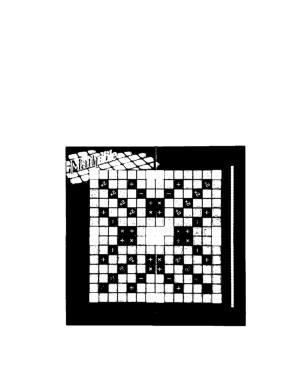

(1974, 1976, 3)


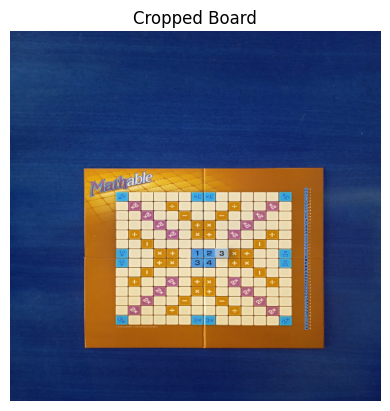

Identified piece as 63


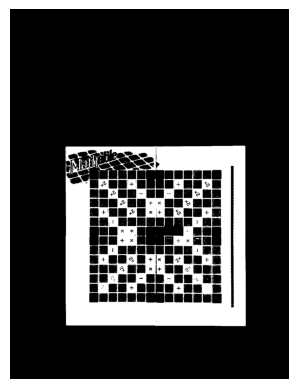

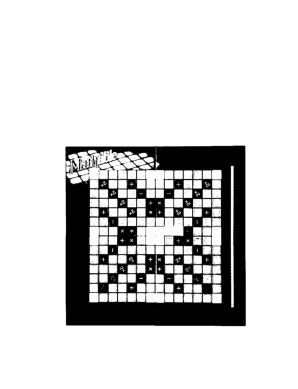

(57, 82, 3)


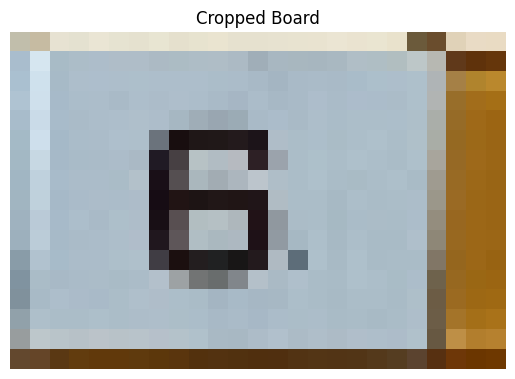

Identified piece as 5


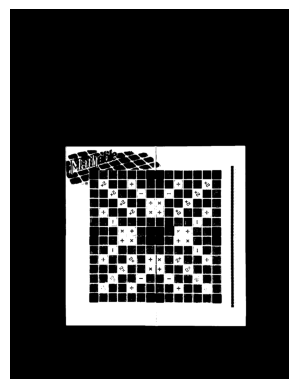

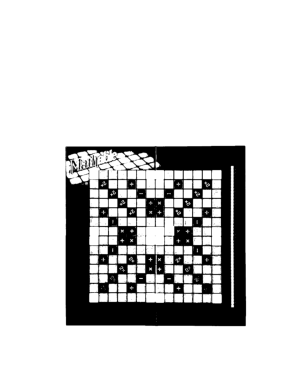

(1973, 1980, 3)


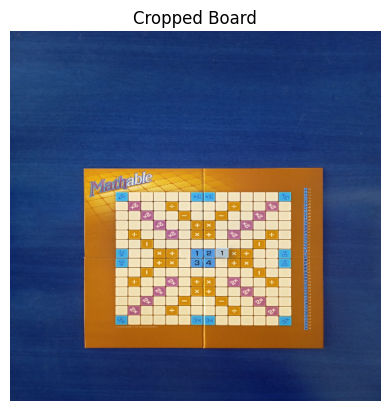

Identified piece as 63


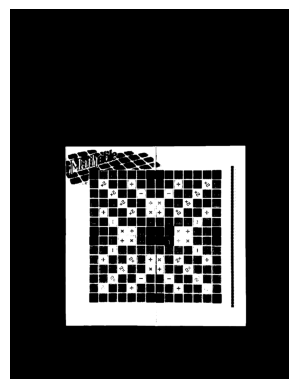

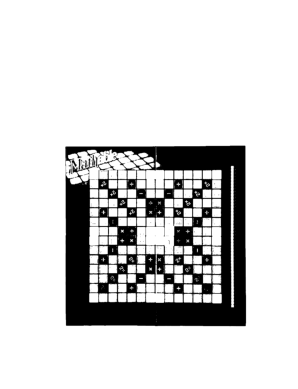

(60, 88, 3)


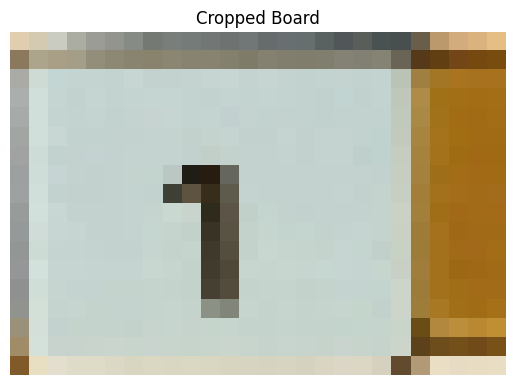

Identified piece as 13


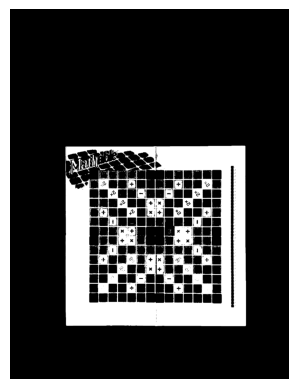

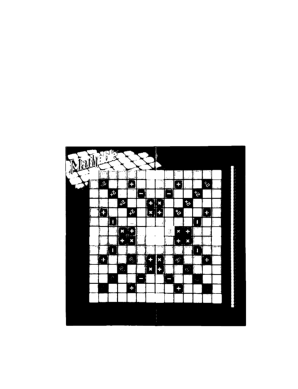

(1971, 1977, 3)


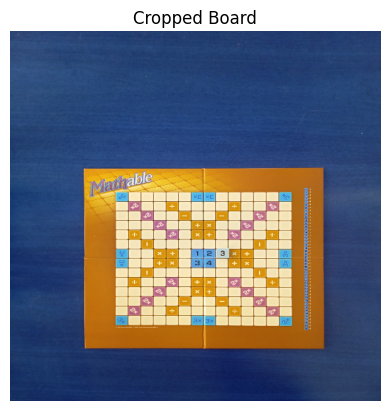

In [ ]:
for game in range(1, nGames + 1):
    trainImages = [image for image in trainImagesCopy if image.startswith(str(game))]
    iterations = 2
    previousRoundBoard = boardTemplate
    for img in trainImages:
        image = cv.imread(os.path.join(trainDir, img))

        cutoutBoard = getBoard(image)
        resizedBoard = resizeBoard(cutoutBoard, 1980, 1980)
        currentBoardHSV = cv.cvtColor(resizedBoard, cv.COLOR_BGR2HSV)
        previousBoardHSV = cv.cvtColor(previousRoundBoard, cv.COLOR_BGR2HSV)

        valueDifference = cv.absdiff(currentBoardHSV[:, :, 2], previousBoardHSV[:, :, 2])
        # showImage('HSV Value difference', valueDifference)
        _, valueThreshold = cv.threshold(valueDifference, 50, 255, cv.THRESH_BINARY)
        # showImage('HSV Value threshold', valueThreshold)

        kernel = np.ones((3, 3), np.uint8)
        dilatedDifference = cv.dilate(valueThreshold, kernel)
        # showImage('Dilated Value difference', dilatedDifference)

        contours, _ = cv.findContours(dilatedDifference,  cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv.contourArea)

        resizedCopy = resizedBoard.copy()
        cv.drawContours(resizedCopy, [largest_contour], -1, (0, 255, 0), 3)
        # showImage("Contour", resizedCopy)

        x, y, w, h = cv.boundingRect(largest_contour)
        croppedBoard = resizedBoard[y:y+h, x:x+w]
        print(croppedBoard.shape)
        showImage("Cropped Board", croppedBoard)

        identifiedPiece = matchPiece(croppedBoard)
        print(f'Identified piece as {identifiedPiece}')

        previousRoundBoard = resizedBoard

        iterations -= 1
        if iterations == 0:
            break